In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import LaneLines
from sklearn.svm                import LinearSVC
from sklearn.preprocessing      import StandardScaler
from sklearn.model_selection    import train_test_split
from scipy.ndimage.measurements import label
from skimage.feature            import hog
from sklearn.utils              import shuffle
from moviepy.editor             import VideoFileClip

%matplotlib inline

orient          = 10  
pix_per_cell    = 10 
cell_per_block  = 3 
hist_bins       = 32  
spatial_size    = (16, 16)


threshold      = 3
alpha          = 0.75 

track_list     = []
threshold_len  = 32
y_min          = 440

heat_p         = np.zeros((720, 1280)) 
boxes_p        = []
n_count        = 0 
mtx            = None 
dist           = None

## 1. Features Extraction

In [2]:
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: 
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:     
        features           = hog(img, orientations=orient, 
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block), 
                                transform_sqrt=True, 
                                visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size):
    return cv2.resize(img, size).ravel() 

In [3]:
def img_features(feature_image, hist_bins, orient, pix_per_cell, cell_per_block):
    file_features    = []
    spatial_features = bin_spatial(feature_image, size=spatial_size) 
    file_features.append(spatial_features) 
    
    hist_features    = color_hist(feature_image, nbins=hist_bins)     
    file_features.append(hist_features)
        
    feature_image   = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
    feature_image   = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
    hog_features    = get_hog_features(feature_image[:,:], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    file_features.append(hog_features)
    return file_features

def extract_features(imgs, spatial_size,hist_bins, orient, pix_per_cell, cell_per_block):
    features          = []
    
    for images in imgs:
        file_features = []
        image         = cv2.imread(images) 
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)     
        
        file_features = img_features(feature_image , hist_bins, orient, 
                        pix_per_cell, cell_per_block)
        features.append(np.concatenate(file_features))
        
        feature_image=cv2.flip(feature_image,1) 
        file_features = img_features(feature_image, hist_bins, orient, 
                        pix_per_cell, cell_per_block)
        features.append(np.concatenate(file_features))

    return features 

## 2. Loading Data Set

In [4]:
def read_data_set(data_set_dir):
    images = glob.glob(data_set_dir)
    cars = []
    notcars = []
    for image in images:
        if 'non' in image:
            notcars.append(image)
        else:
            cars.append(image)
         
    print('Cars images', len(cars))
    print('Not-Car images',len(notcars))
    return notcars,cars;

In [5]:
def show_random_samples(cars,notcars,viewHOG = False):
    fig = plt.figure(figsize=(10, 12))
    for r in range(6):
        img = fig.add_subplot(3,2,r+1)
        if r%2==0:
            idx = r
            if(viewHOG==True):
                sample = cv2.imread(cars[idx])
                sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
                _,HOGimg  = get_hog_features(sample[:,:], 8, 8, 2,True)
                plt.imshow(HOGimg)
                img.set_title("Vehicle Image HOG")
            else:
                plt.imshow(mpimg.imread(cars[idx]),cmap='gray')
                img.set_title("Vehicle Image")
            
        else:
            idx = r
            if(viewHOG==True):
                sample = cv2.imread(notcars[idx])
                sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
                _,HOGimg  = get_hog_features(sample[:,:], 8, 8, 2,True)    
                plt.imshow(HOGimg)
                img.set_title("Non Vehicle Image HOG")
            else:
                plt.imshow(mpimg.imread(notcars[idx]),cmap='gray')
                img.set_title("Non Vehicle Image")
        
        img.set_xticks([])
        img.set_yticks([])

    plt.show()

Cars images 8792
Not-Car images 8968


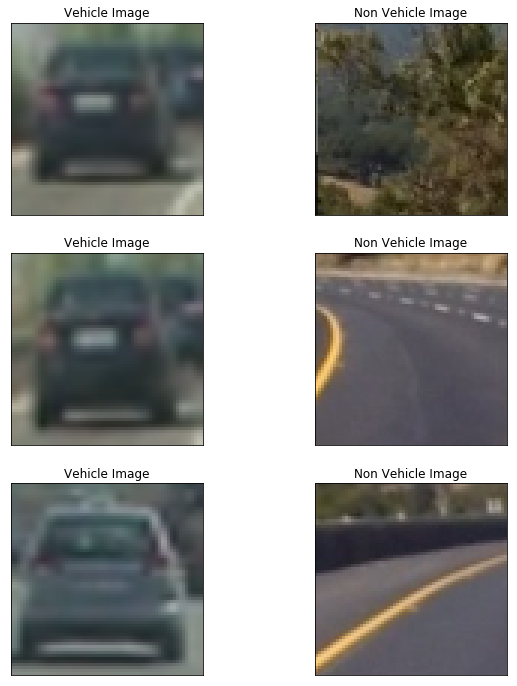

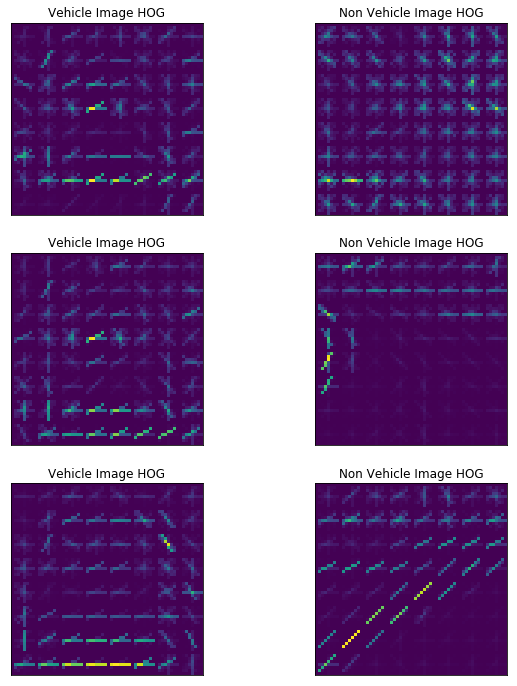

In [6]:
notcars,cars = read_data_set('*vehicles/*/*/*/*.png')
show_random_samples(cars,notcars)
show_random_samples(cars,notcars,True)


## 3. Classifier and Data Set Setup

In [7]:
car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)

print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)

print ('Notcar samples: ', len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X) 
y        = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) 

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

svc = LinearSVC(loss='hinge')  
svc.fit(X_train, y_train) 

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) 

Car samples:  17584
Notcar samples:  17936
Test Accuracy of SVC =  0.9899


## 4. Car Extraction and Frame Processing

In [8]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap 
    
def apply_threshold(heatmap, threshold): 
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a,b,alpha): 
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p):
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))

def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes: 
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [9]:
def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    window              = 64
    boxes               = []
    draw_img            = np.zeros_like(img)   
    img_tosearch        = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch     = convert_color(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))  
        
    ch1                 = ctrans_tosearch[:,:,0]
    cells_per_step      = step  
    nxblocks            = (ch1.shape[1] // pix_per_cell)-1
    nyblocks            = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block     = orient*cell_per_block**2

 
    nblocks_per_window  = (window // pix_per_cell) -1

    nxsteps             = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps             = (nyblocks - nblocks_per_window) // cells_per_step

    hog1                = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos       = yb*cells_per_step
            xpos       = xb*cells_per_step

            hog_f      = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft      = xpos*pix_per_cell
            ytop       = ypos*pix_per_cell
            subimg     = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
        
            spatial_f  = bin_spatial(subimg, size=spatial_size)
            hist_f     = color_hist(subimg, nbins=hist_bins)
            test_f     = X_scaler.transform(np.hstack((spatial_f, hist_f, hog_f)).reshape(1, -1))  
            
            test_pred  = svc.predict(test_f)
            if test_pred == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw  = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

In [10]:
def draw_labeled_bboxes(labels):
    global track_list
    track_list_l = []
    boxes        = []
    for car_number in range(1, labels[1]+1):
        nonzero  = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox     = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        size_x   = (bbox[1][0]-bbox[0][0])/2.0 #Size of the found box
        size_y   = (bbox[1][1]-bbox[0][1])/2.0
        
        asp_d    = size_x / size_y
        size_m   = (size_x + size_y)/2
        
        x        = size_x+bbox[0][0]
        y        = size_y+bbox[0][1]
        asp = (y-y_min)/130.0+1.2 
        if x>1050 or x<230:
            asp*=1.4
        asp     = max(asp, asp_d)
        size_ya = np.sqrt(size_x*size_y/asp)
        size_xa = int(size_ya*asp)
        size_ya = int(size_ya)
        
        if x > (-3.049*y+1809): 
            track_list_l.append(np.array([x, y, size_xa, size_ya]))
            if len(track_list) > 0:
                track_l = track_list_l[-1]
                dist    = []
                for track in track_list:
                    dist.append(len_points(track, track_l))
                min_d   = min(dist)
                
                if min_d < threshold_len:
                    ind = dist.index(min_d)
                    track_list_l[-1] = filt(track_list[ind], track_list_l[-1], alpha)
                    
    track_list = track_list_l
    for track in track_list_l:
        boxes.append(track_to_box(track))
    return boxes

def frame_proc(img,video = True):
    if (video and n_count%2==0) or not video:
        global heat_p, boxes_p, n_count
        
        heat  = np.zeros_like(img[:,:,0]).astype(np.float)
        boxes = []
        boxes = find_cars(img, 400, 650, 950, 1280, 2.0, 2)
        boxes += find_cars(img, 400, 500, 950, 1280, 1.5, 2)
        boxes += find_cars(img, 400, 650, 0, 330, 2.0, 2)
        boxes += find_cars(img, 400, 500, 0, 330, 1.5, 2)
        boxes += find_cars(img, 400, 460, 330, 950, 0.75, 3)
        
        for track in track_list:
            y_loc  = track[1] + track[3]
            lane_w = (y_loc*2.841-1170.0)/3.0
            
            if lane_w < 96:
                lane_w = 96
                
            lane_h = lane_w/1.2
            lane_w = max(lane_w, track[2])
            
            xs     = track[0]-lane_w
            xf     = track[0]+lane_w
            
            if track[1] < y_min:
                track[1] = y_min
                
            ys    = track[1]-lane_h   
            yf    = track[1]+lane_h
            
            if xs < 0: xs=0
            if xf > 1280: xf=1280
            if ys < y_min - 40: ys=y_min - 40
            if yf > 720: yf=720
                
            size_sq = lane_w / (0.015*lane_w+0.3)
            scale   = size_sq / 64.0
            

            boxes  += find_cars(img, ys, yf, xs, xf, scale, 2)
            boxes  += find_cars(img, ys, yf, xs, xf, scale*1.25, 2)
            boxes  += find_cars(img, ys, yf, xs, xf, scale*1.5, 2)
            boxes  += find_cars(img, ys, yf, xs, xf, scale*1.75, 2)

        heat       = add_heat(heat, boxes)
        heat_l     = heat_p + heat
        heat_p     = heat
        heat_l     = apply_threshold(heat_l,threshold)  
        heatmap    = np.clip(heat_l, 0, 255)
        labels     = label(heatmap)
        cars_boxes = draw_labeled_bboxes(labels)
        boxes_p    = cars_boxes  
    else:
        cars_boxes = boxes_p
        
    img            = LaneLines.draw_line(img,mtx,dist)
    imp            = draw_boxes(np.copy(img), cars_boxes, color=(0,255, 0), thick=2)
    n_count += 1
    return imp

In [12]:
n_count = 0
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image), cv2.COLOR_BGR2RGB)

mtx , dist = LaneLines.cam_calibration('camera_cal/', 9, 6, (720, 1280))
output_v = 'project_video_proc.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:32<00:00,  4.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

Wall time: 4min 33s
